In [1]:
import pandas as pd
import numpy as np
import os
from tslearn.shapelets import LearningShapelets
from tslearn.preprocessing import TimeSeriesScalerMinMax
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict
import random

## Understanding the RR Interval Data

This dataset contains time series of **RR intervals**, which are the durations between consecutive R-waves in the heart's electrical signal, as recorded by an implanted cardioverter-defibrillator (ICD).  

Each R-wave corresponds to a heartbeat, and the RR interval (measured in milliseconds) reflects the time between two successive beats. For example:
- An RR interval of **1000 ms** corresponds to **60 beats per minute** (bpm),
- An RR interval of **500 ms** corresponds to **120 bpm**.

In this dataset:
- The RR intervals were measured from patients implanted with **Medtronic Jewel Plus™ ICD 7218** devices.
- These measurements were automatically extracted from the **P-/S – P+/S (Tip–Ring)** EGM channel.
- Each RR sequence captures either:
  - A **spontaneous ventricular arrhythmia** episode (VT or VF),
  - Or a **baseline rhythm** snapshot (typically sinus rhythm), recorded during a check-up.

The RR intervals are **truncated** (not rounded) to the nearest 10 milliseconds by the ICD. For example, a true interval of 457 ms is recorded as 450 ms.

Each time series in the dataset contains between **986 and 1024** RR intervals:
- VT/VF sequences are always **1024 intervals**, ending at the moment the ICD **detected** the event (not when it ended).
- Baseline sequences ("most recent", labeled `mr`) are **986–1022 intervals** long due to partial loss during device interrogation.

These RR interval sequences allow researchers to study:
- How the heart rhythm changes **prior to ventricular tachyarrhythmias**,
- And whether specific patterns in RR intervals can **predict dangerous events**.


In [2]:
base_dir = "spontaneous-ventricular-tachyarrhythmia-database-1.0"
healthy_dir = os.path.join(base_dir, "mr")
sick_dir = os.path.join(base_dir, "RRdata1")

all_data = []


def parse_filename(fname):  # described on the website
    base, ext = fname.split(".")
    patient_id = base  # first 4 digits
    type_code = ext[:2]  # vt, vf, mr
    seq_num = ext[2:]  # the number part, e.g., '2' or 'a'
    return patient_id, type_code, seq_num


for fname in sorted(os.listdir(healthy_dir)):
    fpath = os.path.join(healthy_dir, fname)
    if os.path.isfile(fpath):
        data = np.loadtxt(fpath)
        patient_id, type_code, seq_num = parse_filename(fname)
        all_data.append(
            {
                "patient_id": patient_id,
                "type": type_code,
                "seq_num": seq_num,
                "rr_intervals": data,
            }
        )

for fname in sorted(os.listdir(sick_dir)):
    fpath = os.path.join(sick_dir, fname)
    if os.path.isfile(fpath) and (".vt" in fname or ".vf" in fname):
        data = np.loadtxt(fpath)
        patient_id, type_code, seq_num = parse_filename(fname)
        all_data.append(
            {
                "patient_id": patient_id,
                "type": type_code,
                "seq_num": seq_num,
                "rr_intervals": data,
            }
        )

df = pd.DataFrame(all_data)

print(
    f"Loaded {len(df[df['type'].isin(['vt', 'vf'])])} sick and {len(df[df['type'].isin(['mr', 'mra'])])} healthy sequences."
)

Loaded 135 sick and 135 healthy sequences.


# EDA

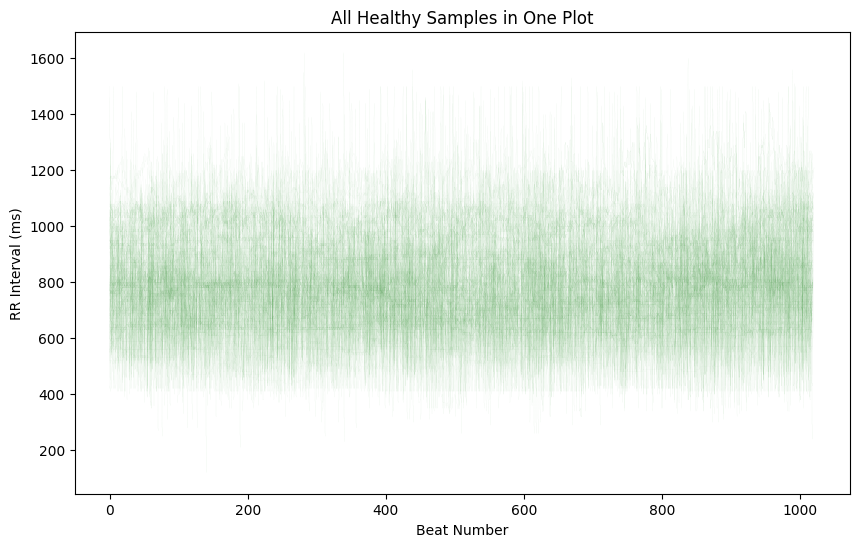

In [3]:
healthy_samples = df[df["type"] == "mr"]["rr_intervals"]

plt.figure(figsize=(10, 6))

for sample in healthy_samples:
    plt.plot(sample, color="g", linewidth=0.01)

plt.title("All Healthy Samples in One Plot")
plt.xlabel("Beat Number")
plt.ylabel("RR Interval (ms)")
plt.show()

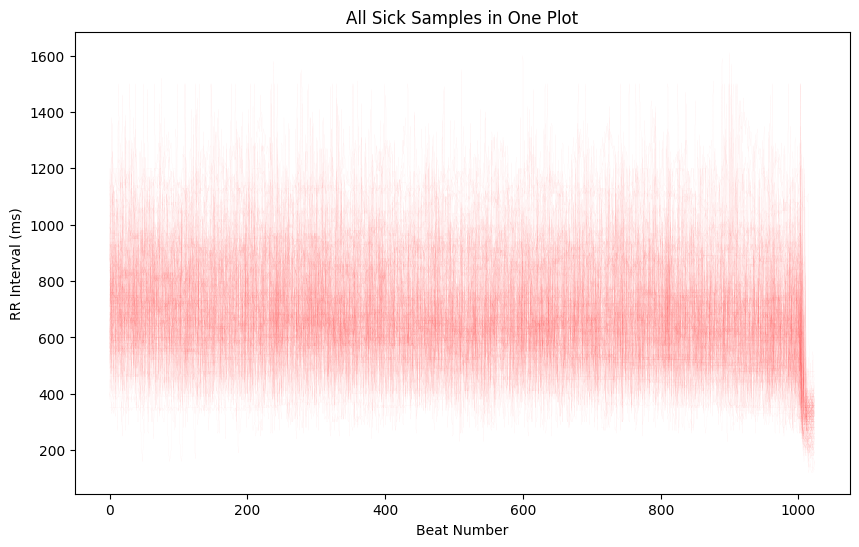

In [4]:
sick_samples = df[df["type"].isin(["vt", "vf"])]["rr_intervals"]

plt.figure(figsize=(10, 6))

for sample in sick_samples:
    plt.plot(sample, color="r", linewidth=0.01)

plt.title("All Sick Samples in One Plot")
plt.xlabel("Beat Number")
plt.ylabel("RR Interval (ms)")
plt.show()

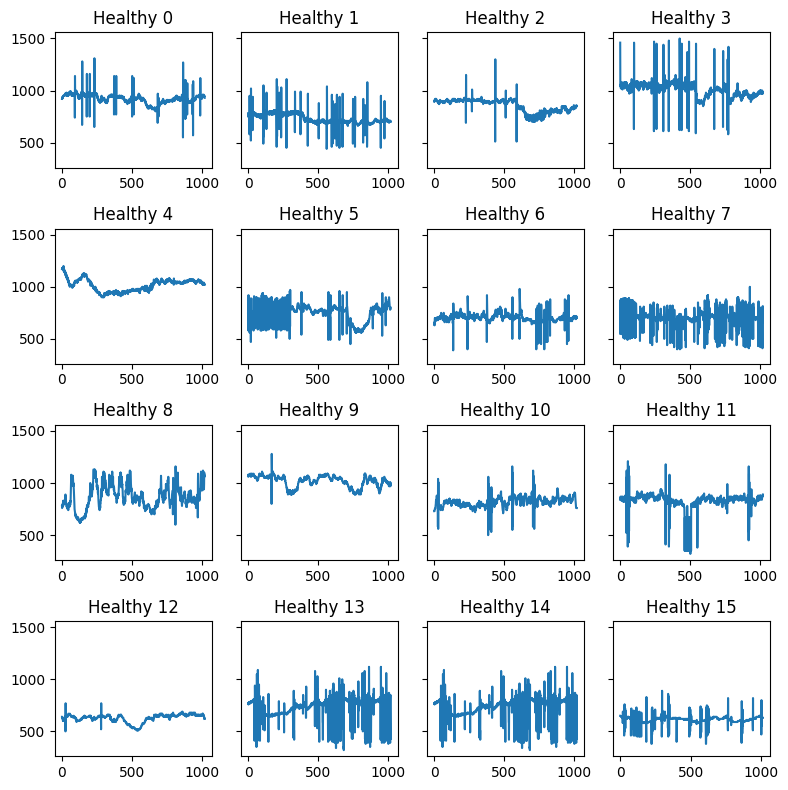

In [5]:
fig, axs = plt.subplots(4, 4, figsize=(8, 8), sharey=True)
for i in range(16):
    row = i // 4
    col = i % 4
    axs[row, col].plot(healthy_samples[i])
    axs[row, col].set_title(f"Healthy {i}")

plt.tight_layout()
plt.show()

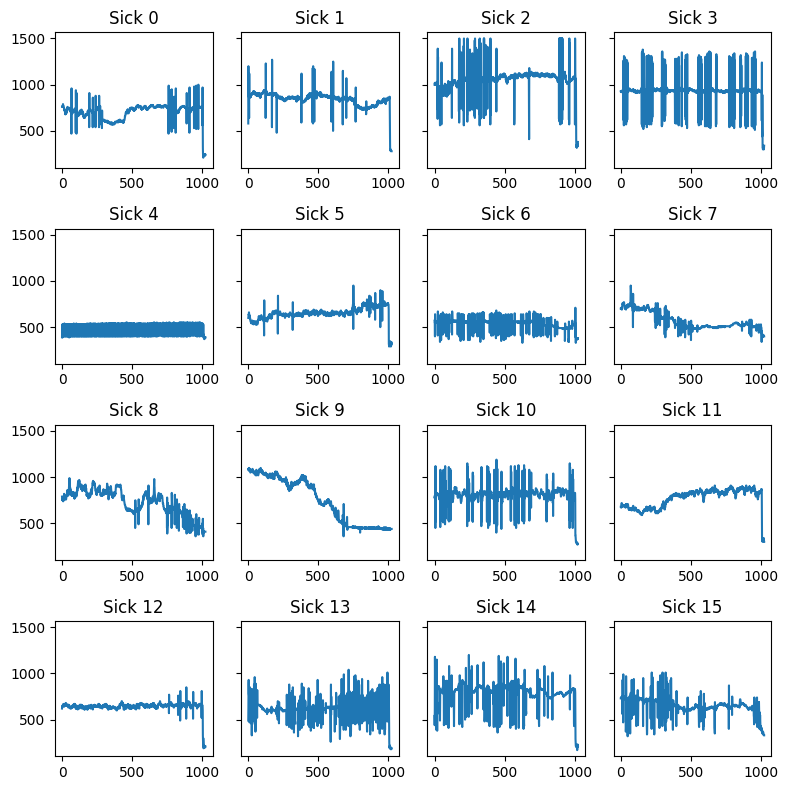

In [6]:
fig, axs = plt.subplots(4, 4, figsize=(8, 8), sharey=True)

for i in range(16):
    row = i // 4
    col = i % 4
    axs[row, col].plot(sick_samples.iloc[i])
    axs[row, col].set_title(f"Sick {i}")

plt.tight_layout()
plt.show()

### Exercise: Pair Each Abnormal Event with Its Baseline

In [7]:
# TODO:
# 1. Loop over all sick rows in the DataFrame

# 2. Find a matching baseline row (patient_id, sequence_number)

# 3.1 If a match is found
# 3.2 Add a dictionary to the 'paired' list containing:
# - Patient ID
# - Event type ('vt' or 'vf')
# - Sequence number
# - RR intervals for the event
# - RR intervals for the matched baseline (or reference)

paired = []
for _, row in df[df["type"].isin(["vt", "vf"])].iterrows():
    match = df[
        (df["patient_id"] == row["patient_id"])
        & (df["seq_num"] == row["seq_num"])
        & (df["type"] == "mr")
    ]
    if not match.empty:
        paired.append(
            {
                "patient_id": row["patient_id"],
                "type": row["type"],
                "seq_num": row["seq_num"],
                "event_rr": row["rr_intervals"],
                "baseline_rr": match.iloc[0]["rr_intervals"],
            }
        )


print(f"Paired {len(paired)} event-baseline pairs.")
paired_df = pd.DataFrame(paired)

Paired 135 event-baseline pairs.


In [8]:
patient_ids = paired_df["patient_id"].unique()
print(f"Total patients: {len(patient_ids)}")

random.seed(42)
patient_ids = list(patient_ids)
random.shuffle(patient_ids)

train_split = 0.8
test_split = 0.2

n_patients = len(patient_ids)
train_idx = int(train_split * n_patients)

train_patients = set(patient_ids[:train_idx])


def assign_split(pid):
    if pid in train_patients:
        return "train"
    else:
        return "test"


paired_df["split"] = paired_df["patient_id"].apply(assign_split)

print(paired_df["split"].value_counts())

Total patients: 78
split
train    108
test      27
Name: count, dtype: int64


In [9]:
def prepare_xy(subset_df, ts_length=950):
    X = []
    y = []
    for _, row in subset_df.iterrows():
        X.append(row["event_rr"][-ts_length:])
        y.append(1)
        X.append(row["baseline_rr"][-ts_length:])
        y.append(0)
    return np.array(X), np.array(y)


X_train, y_train = prepare_xy(paired_df[paired_df["split"] == "train"])
X_test, y_test = prepare_xy(paired_df[paired_df["split"] == "test"])

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (216, 950), Test: (54, 950)


In [10]:
scaler = TimeSeriesScalerMinMax()
X_train = np.squeeze(scaler.fit_transform(X_train))
X_test = np.squeeze(scaler.transform(X_test))

# SAX

## 📈 Symbolic Aggregate approXimation (SAX)

**SAX** (Symbolic Aggregate approXimation) is a method for summarizing and analyzing continuous time series data by transforming it into a symbolic representation. Originally developed for speech recognition, SAX has been widely applied in **medical time series analysis**, such as ECG and EEG signals.

### 🔍 How SAX Works

1. **Segment the time series** into a fixed number of equal-length subsequences.
2. **Compute mean and standard deviation** for each subsequence.
3. **Map the standard deviation** of each segment to a symbol using a predefined alphabet, based on breakpoints.
4. **Concatenate the symbols** to form a discrete sequence representation of the original time series.

This produces a compact and symbolic string:  
`SAX(X) = [f(s₁), f(s₂), ..., f(sₖ)]`

Where:
- `X = [x₁, x₂, ..., xₙ]` is the input time series.
- `w` is the subsequence length.
- `k = n / w` is the number of segments.
- `s(i)` is the standard deviation of segment `i`.
- `f(s(i))` maps the std to a symbol based on breakpoints `B = [b₁, ..., bₐ₋₁]`.

### 📊 Why Use SAX?

- **Compact representation** for long time series
- **Fast similarity search**, pattern matching, and classification
- **Robust to noise**
- Useful for **detecting abnormal patterns** (e.g., cardiac arrhythmia, seizures)

### ⚠️ Limitations

- Discretization may lose fine-grained information
- Does not directly capture temporal dependencies
- May need to be combined with other methods for high-accuracy medical diagnosis

---

### 🏥 Applications in Medicine

- **ECG Analysis**: Detect arrhythmia, heart rate variability
- **EEG Analysis**: Identify seizure patterns or brainwave anomalies
- Used as a **preprocessing step** before classification or clustering


In [11]:
def sax(ts, window_size, alphabet_size, function=np.std, breakpoints=None):
    """
    SAX-like transform based on standard deviation.

    Parameters:
        ts (np.ndarray): 1D time series
        window_size (int): window size
        alphabet_size (int): alphabet size
        breakpoints (list or None): breakpoints for std-based mapping

    Returns:
        list[str]: Symbolic sequence
    """
    if breakpoints is None:
        breakpoints = np.linspace(0, np.std(ts) * 2, alphabet_size)[1:]

    symbols = []
    alphabet = [i for i in range(alphabet_size)]
    # TODO
    # 1. Iterate through the time series in steps of `window_size` (non-overlapping segments)
    # 2. Extract the current segment (window) of the time series
    # 3. Compute the standard deviation of this segment
    # 4. Compare the segment's std to the breakpoints to determine which symbol to assign

    for i in range(0, len(ts) - window_size + 1, window_size):
        window = ts[i : i + window_size]
        value = function(window)
        for j, bp in enumerate(breakpoints):
            if value < bp:
                symbols.append(alphabet[j])
                break
        else:
            symbols.append(alphabet[-1])

    return symbols

In [12]:
window_size = 50
alphabet_size = 4

X_train_sax = np.array(
    [
        sax(
            ts,
            window_size=window_size,
            alphabet_size=alphabet_size,
        )
        for ts in X_train
    ]
)
X_test_sax = np.array(
    [
        sax(
            ts,
            window_size=window_size,
            alphabet_size=alphabet_size,
        )
        for ts in X_test
    ]
)

AUC: 0.8704


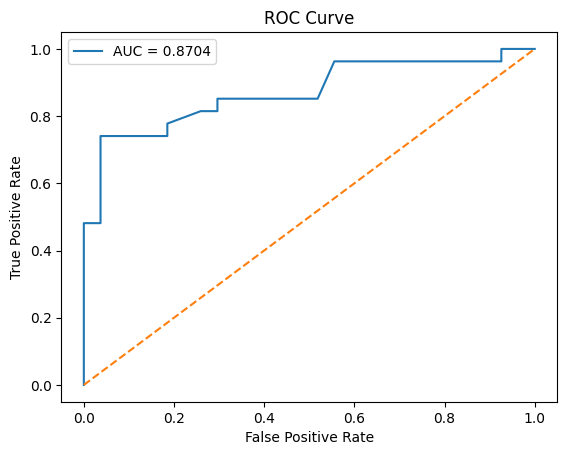

In [13]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_sax, y_train)

y_proba = clf.predict_proba(X_test_sax)[:, 1]

auc = roc_auc_score(y_test, y_proba)
print(f"AUC: {auc:.4f}")

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

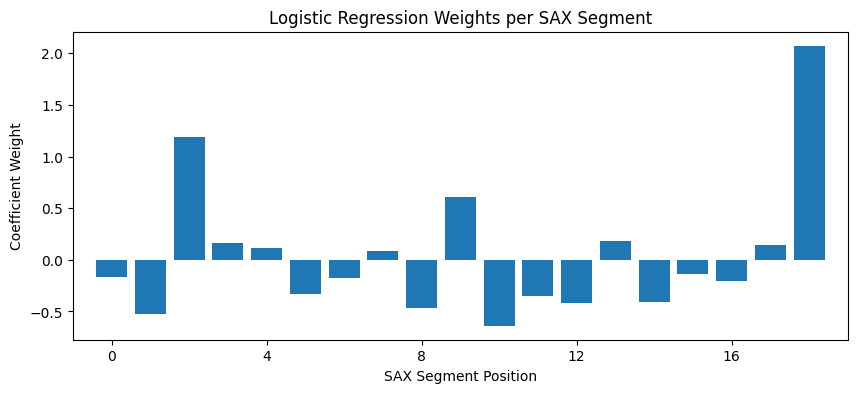

In [14]:
coefs = clf.coef_[0]
plt.figure(figsize=(10, 4))
plt.bar(range(len(coefs)), coefs)
plt.xlabel("SAX Segment Position")
plt.ylabel("Coefficient Weight")
plt.title("Logistic Regression Weights per SAX Segment")
plt.xlim(-1, len(coefs))
plt.xticks(range(len(coefs))[::4])
plt.show()

In [15]:
df_sax = pd.DataFrame(
    X_train_sax, columns=[f"pos_{i}" for i in range(X_train_sax.shape[1])]
)
df_sax["label"] = y_train

symbol_modes = df_sax.groupby("label").agg(lambda x: pd.Series.mode(x)[0])

print("Most common symbols per class:")
print(symbol_modes.T)

Most common symbols per class:
label   0  1
pos_0   0  0
pos_1   0  0
pos_2   0  0
pos_3   0  0
pos_4   0  0
pos_5   0  0
pos_6   0  0
pos_7   0  0
pos_8   0  0
pos_9   0  0
pos_10  0  0
pos_11  0  0
pos_12  0  0
pos_13  0  0
pos_14  0  0
pos_15  0  0
pos_16  0  0
pos_17  1  0
pos_18  0  3


# LAXCAT

### 🧠 Learning from Aggregate Xtreme Categories with Automated Transformation (LAXCAT)

**LAXCAT** (Learning from Aggregate Xtreme Categories with Automated Transformation) is a feature extraction technique for time series data introduced by Hsieh et al. (2021). It aims to extract and emphasize **extreme patterns** from temporal signals—especially useful in clinical or physiological datasets—by transforming basic statistics into nonlinear features.

This method is particularly effective when:
- Detecting rare or extreme physiological events (e.g., arrhythmia).
- Identifying subtle segment-level abnormalities in long recordings.
- Complementing simpler symbolic representations like SAX.

---

### 📌 Algorithm Overview

LAXCAT transforms a time series through the following steps:

1. **Segment the series**  
   Divide the time series into **fixed-length segments** or use a **sliding window** approach.

2. **Compute statistical features per segment**  
   For each segment \( X_i \), extract statistical features like:
   - Mean
   - Variance
   - Skewness
   - Kurtosis

3. **Apply a non-linear transformation**  
   Transform each computed feature using a nonlinear function (e.g., **tanh** or **sigmoid**) to **emphasize extremeness**.

4. **Create a flattened feature vector**  
   Combine transformed features from all segments into a flat vector, ready for input into a classifier or clustering model.

---

### ✅ Why Use LAXCAT?

- **Captures rare but important signals** (outliers may hold diagnostic value).
- Produces fixed-length, interpretable feature vectors.
- Works well with standard ML classifiers like SVMs or Random Forests.
- Has been used in medical applications such as:
  - Adverse event prediction
  - Patient stratification
  - Signal/image classification

---

### ⚠️ Limitations

- Sensitive to:
  - Segment/window length
  - Choice of aggregation functions
  - Feature scaling
- May struggle with variable-length or noisy data without preprocessing
- Should ideally be used alongside other techniques (like SAX or shapelets)


In [16]:
from scipy.stats import skew, kurtosis


def laxcat_features(ts, window_size=50, agg_funcs=None, nonlinearity="sigmoid"):
    """
    LAXCAT feature extraction based on textual description.

    Parameters:
        ts (np.ndarray): 1D time series
        window_size (int): length of each segment
        k (float): threshold multiplier for extreme value detection
        agg_funcs (list): list of functions to compute aggregate features per segment
        nonlinearity (str): 'tanh' or 'sigmoid' for feature transformation

    Returns:
        np.ndarray: Feature matrix (segments x transformed aggregate features)
    """
    # TODO
    # 1. Calculate how many full, non-overlapping segments can be made from the time series

    # 2. Split the time series into equal-length segments (each of length window_size)

    # 3.1 Initialize list to hold features for each segment
    # 3.2 Apply each aggregation function to the current segment
    # 3.3 Convert the list of feature vectors into a 2D NumPy array

    # 4. Apply a non-linear transformation to the features to emphasize extremes

    # 5. Flatten the 2D feature matrix into a 1D feature vector and return

    num_segments = len(ts) // window_size
    segments = np.array(
        [ts[i * window_size : (i + 1) * window_size] for i in range(num_segments)]
    )

    if agg_funcs is None:
        agg_funcs = [np.mean, np.var, skew, kurtosis]

    features = []
    for seg in segments:
        seg_feats = [func(seg[~np.isnan(seg)]) for func in agg_funcs]
        features.append(seg_feats)
    features = np.array(features)

    if nonlinearity == "tanh":
        transformed = np.tanh(features)
    elif nonlinearity == "sigmoid":
        transformed = 1 / (1 + np.exp(-features))
    else:
        raise ValueError("nonlinearity must be 'tanh' or 'sigmoid'")

    return transformed.flatten()

In [17]:
X_train_laxcat = np.array(
    [
        laxcat_features(
            ts,
            window_size=50,
            agg_funcs=[np.mean, np.var, skew, kurtosis],
            nonlinearity="tanh",
        )
        for ts in X_train
    ]
)


X_test_laxcat = np.array(
    [
        laxcat_features(
            ts,
            window_size=50,
            agg_funcs=[np.mean, np.var, skew, kurtosis],
            nonlinearity="tanh",
        )
        for ts in X_test
    ]
)

X_train_laxcat = np.nan_to_num(X_train_laxcat, nan=0.0)

X_test_laxcat = np.nan_to_num(X_test_laxcat, nan=0.0)


print(X_train_laxcat.shape)

C:\Users\zita.zarandy\AppData\Local\Temp\ipykernel_44448\4204846168.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  seg_feats = [func(seg[~np.isnan(seg)]) for func in agg_funcs]


(216, 76)


AUC: 0.8971


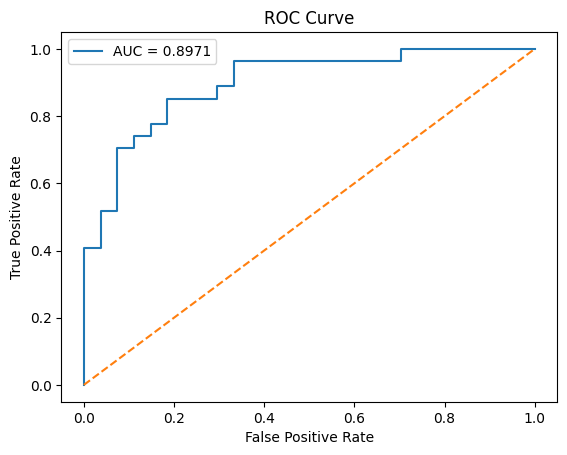

In [18]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_laxcat, y_train)

y_proba = clf.predict_proba(X_test_laxcat)[:, 1]

auc = roc_auc_score(y_test, y_proba)
print(f"AUC: {auc:.4f}")

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

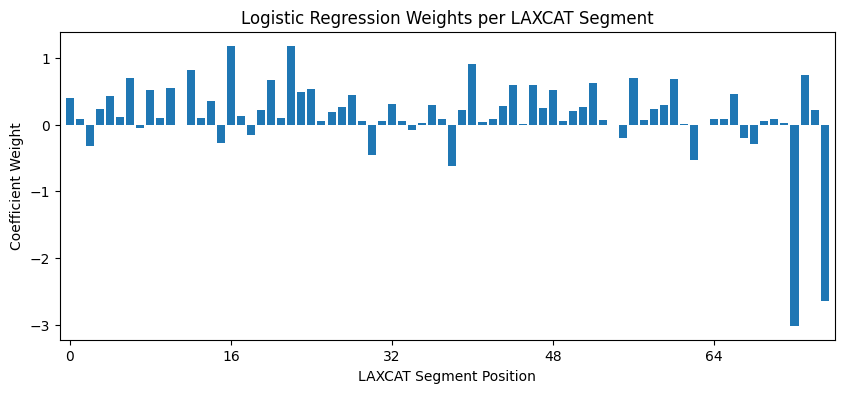

In [19]:
coefs = clf.coef_[0]
plt.figure(figsize=(10, 4))
plt.bar(range(len(coefs)), coefs)
plt.xlabel("LAXCAT Segment Position")
plt.ylabel("Coefficient Weight")
plt.title("Logistic Regression Weights per LAXCAT Segment")
plt.xlim(-1, len(coefs))
plt.xticks(range(len(coefs))[::16])
plt.show()

# Shapelets

## Learning Shapelets

**Learning Shapelets** is an advanced and more efficient alternative to the traditional shapelet discovery method. Originally introduced by Grabocka et al. (2014), this approach integrates shapelet discovery directly into the learning process of a classifier, rather than treating shapelet extraction and model training as separate steps.

---

### 🔍 What is Learning Shapelets?

Instead of exhaustively searching for the best shapelets in a brute-force manner, **Learning Shapelets**:
- Initializes shapelets randomly.
- Learns their optimal values via **gradient-based optimization** (e.g. backpropagation).
- Simultaneously trains a classifier using these learned shapelets as features.

This turns shapelet discovery into a **differentiable learning problem**, which allows it to scale and generalize better.

---

### 🚀 Why is Learning Shapelets Better?

| Original Shapelet Discovery       | Learning Shapelets                     |
|----------------------------------|----------------------------------------|
| Brute-force search over all possible sub-sequences | Learns shapelets via optimization (efficient) |
| Separate shapelet extraction and classification steps | Joint learning of shapelets and model parameters |
| High computational cost and redundancy | End-to-end differentiable training |
| Hard to scale to large datasets | Easily scalable with mini-batch training |
| Static shapelets | Shapelets adapt to minimize classification loss |

---

### ✅ Benefits of Learning Shapelets

- **Efficiency**: Avoids redundant computations over all possible sub-sequences.
- **Scalability**: Supports large datasets and deep learning frameworks (e.g., TensorFlow).
- **End-to-End Training**: Shapelets are optimized directly for classification performance.
- **Interpretability**: Learned shapelets can still be visualized and interpreted like traditional ones.
- **Regularization**: Can include weight regularization to control complexity and overfitting.

---

### ⚠️ Considerations

- Requires tuning of hyperparameters (e.g., number and length of shapelets).
- May be harder to implement from scratch (but libraries like `tslearn` provide ready-to-use versions).
- Final shapelets may not correspond directly to real sub-sequences but are optimized representations.

---

### 📚 Reference

- Grabocka, J., Schilling, N., Wistuba, M., & Schmidt-Thieme, L. (2014). *Learning Time-Series Shapelets*. ACM SIGKDD.


In [20]:
n_ts, ts_sz = X_train.shape[:2]

shapelet_sizes = grabocka_params_to_shapelet_size_dict(
    n_ts=n_ts, ts_sz=ts_sz, n_classes=2, l=0.03, r=2
)
shapelet_sizes

{28: 5, 56: 5}

In [ ]:
# batch_size = 16
# max_iter = 10000


# model = LearningShapelets(
#     n_shapelets_per_size=shapelet_sizes,
#     optimizer=tf.optimizers.Adam(0.001),
#     batch_size=batch_size,
#     weight_regularizer=1e-5,
#     max_iter=max_iter,
#     random_state=42,
#     verbose=1,
# )

# model.fit(X_train_shapelets, y_train)

c:\Users\zita.zarandy\AppData\Local\anaconda3\envs\tutorial\lib\site-packages\tslearn\shapelets\shapelets.py:353: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Epoch 1/10000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - binary_accuracy: 0.4770 - binary_crossentropy: 0.7029 - loss: 0.7030
Epoch 2/10000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.4960 - binary_crossentropy: 0.7014 - loss: 0.7014
Epoch 3/10000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.4942 - binary_crossentropy: 0.7003 - loss: 0.7003
Epoch 4/10000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.5025 - binary_crossentropy: 0.6992 - loss: 0.6992
Epoch 5/10000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.5032 - binary_crossentropy: 0.6981 - loss: 0.6981
Epoch 6/10000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.5391 - binary_crossentropy: 0.6971 - loss: 0.6971
Epoch 7/10000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.5762 - binary_crossentropy: 0.6961 - loss: 0.6961
Epoch 8/10000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.5791 - binary_crossentropy: 0.6952 - loss: 0.6952
Epoch 9/

In [21]:
model = LearningShapelets.from_pickle("learning_shapelets_model.pkl")

c:\Users\zita.zarandy\AppData\Local\anaconda3\envs\ts_xai_tutorial\lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
c:\Users\zita.zarandy\AppData\Local\anaconda3\envs\ts_xai_tutorial\lib\site-packages\tslearn\shapelets\shapelets.py:353: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


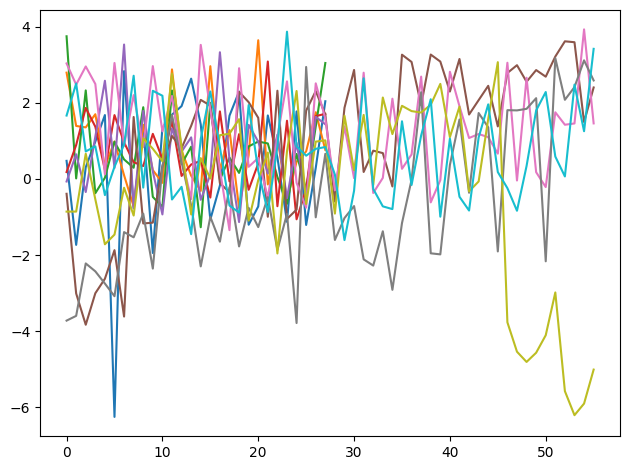

In [22]:
plt.figure()
for shp in model.shapelets_:
    plt.plot(shp.ravel())

plt.tight_layout()
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
AUC: 0.9973


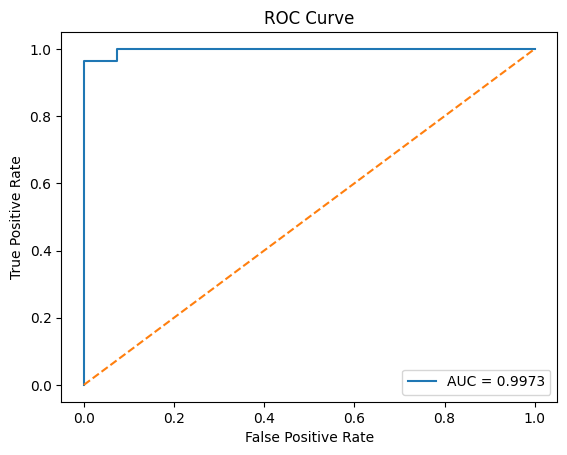

In [23]:
y_proba = model.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, y_proba)
print(f"AUC: {auc:.4f}")

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

LearningShapelets does not expose weights or importance scores directly. So, importance ranking cannot be obtained unless you connect it to a classifier.

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


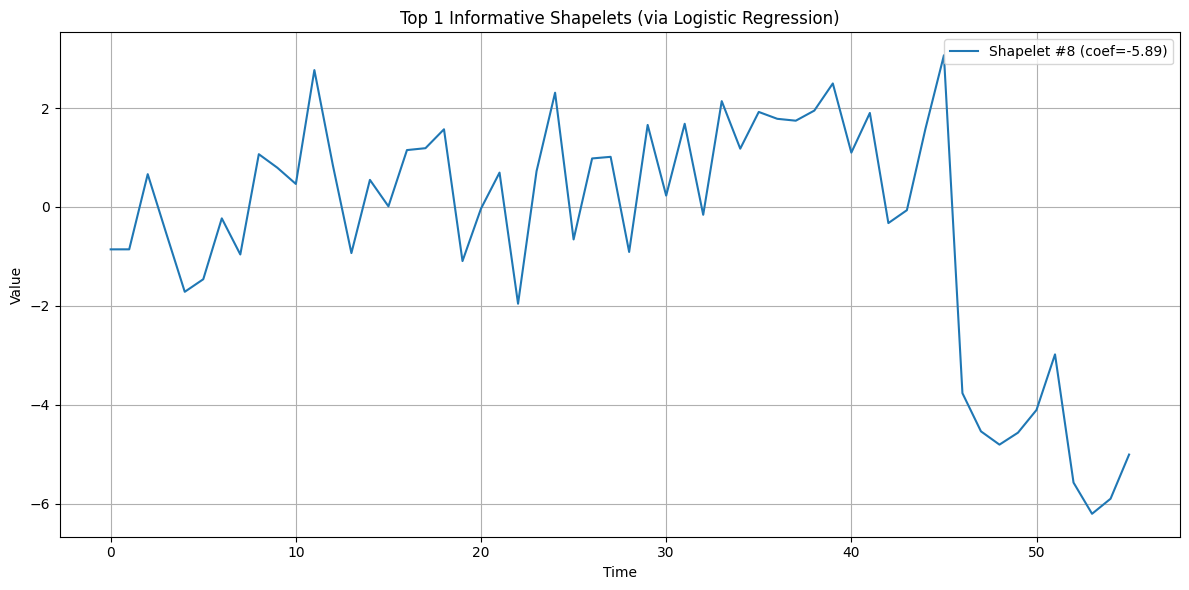

In [24]:
top_k = 1  # number of top shapelets to display
# TODO
# 1. Transform training data using the learned shapelets
# 2. Fit logistic regression on the transformed features
# 3. Extract coefficients (importance of each shapelet)
# 4. Find the indices of the top_k most important shapelets
X_train_transformed = model.transform(X_train)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_transformed, y_train)
coefs = clf.coef_[0]
top_indices = np.argsort(np.abs(coefs))[::-1][:top_k]

shapelets = model.shapelets_
plt.figure(figsize=(12, 6))
for rank, idx in enumerate(top_indices):
    plt.plot(shapelets[idx].ravel(), label=f"Shapelet #{idx} (coef={coefs[idx]:.2f})")
plt.title(f"Top {top_k} Informative Shapelets (via Logistic Regression)")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()